# Feature Reduction Comparison
In this notebook, I explore different means of feature reduction on greyscale images. In specific, I will compare 
 - Principal Component Analysis, 
 - Flat Auto-Encoder, and 
 - Convolutional Auto-encoder. 
 
The results will be compared both visually and in numbers terms of numbers. The scikit dataset of greyscale faces serves as example.

***This is a work in progress***

In [8]:
import numpy as np
from numpy.linalg import eig, eigvals
from sklearn.datasets import fetch_lfw_people
from src.plot_functions import *

np.random.seed(42)

## Loading and Displaying Dataset 

In [172]:
faces = fetch_lfw_people(min_faces_per_person=20, resize=0.4)

n_samples, h, w = faces.images.shape
n_features = h * w
X = faces.data
np.random.shuffle(X)

print("{} samples in dataset".format(n_samples))
print("{} features per sample".format(n_features))
print("{}x{}px image dimension".format(h, w))

3023 samples in dataset
1850 features per sample
50x37px image dimension


In [173]:
# Shuffling and mean normalization
mu_norm = np.mean(X, axis=1)
X_norm = (X.T - mu_norm).T

In [174]:
# Train and test split
test_ratio = 0.2

n_samples_train = int((1-test_ratio) * X.shape[0])
X_train = X_norm[:n_samples_train]
X_test = X_norm[n_samples_train:]
mu_train = mu_norm[:n_samples_train]
mu_test = mu_norm[n_samples_train:]

print("{} samples in train set".format(X_train.shape[0]))
print("{} samples in test set".format(X_test.shape[0]))

2418 samples in train set
605 samples in test set


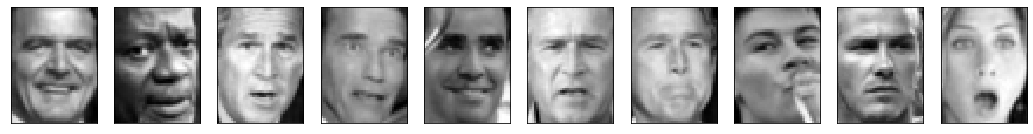

In [175]:
plot_faces(X_train, h, w, 0.8, n_row=1, n_col=10)

## Reduction through PCA

In [176]:
# Compute covariance matrix (equivalent to np.cov(...))
Sigma = 1/n_features * X_train.T.dot(X_train)

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = eig(Sigma)

In [177]:
def get_U_reduce(var_retain, eig):
    """Computes the reduction matrix for PCA"""
    
    eigvals_cumulative = np.array([sum(eig[0:i]) / sum(eig) for i in range(0, len(eig+1))])
    U_n = np.where(eigvals_cumulative >= var_retain)[0][0] + 1
    U_red = eigvecs[:, 0:U_n]
    retention = eigvals_cumulative[U_n-1]
    
    return U_red, retention, eigvals_cumulative

In [178]:
var_retain = 0.99
U_reduce, retention, retention_array = get_U_reduce(var_retain, eigvals)

print("{} features required to retain {:.3f}% of data".format(U_reduce.shape[1], retention*100))

383 features required to retain 99.003% of data


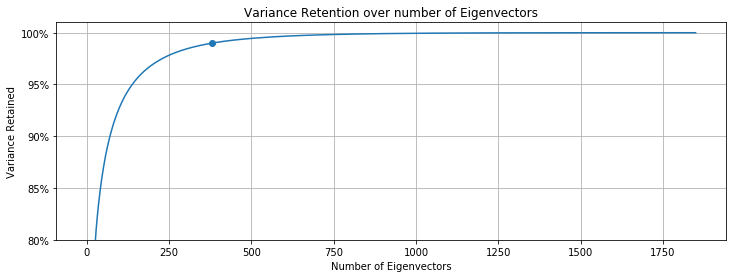

In [179]:
plot_variance_retention(retention_array, var_retain)

In [180]:
def image_similarity(X1, X2):
    """Computes the percentage similarity of two images"""
    
    return 1 - (abs(X1 - X2) / 255.0).mean()

In [181]:
def reduce_and_recover(U_red, X):
    """Reduces features in X according to reduction matrix U_red"""
    
    X_red = X.dot(U_red)
    X_rec = X_red.dot(U_red.T)
    
    return X_rec

In [182]:
# Recover train dataset
X_train_recovered = reduce_and_recover(U_reduce, X_train)

# Reverse the mean normalization
X_train_recovered = (X_train_recovered.T + mu_train).T
X_train_ = (X_train.T + mu_train).T

# Compute the image similarity in %
sim_train = image_similarity(X_train_, X_train_recovered)

print("The train images are {:.3f}% similar".format(sim_train * 100))

The train images are 98.783% similar


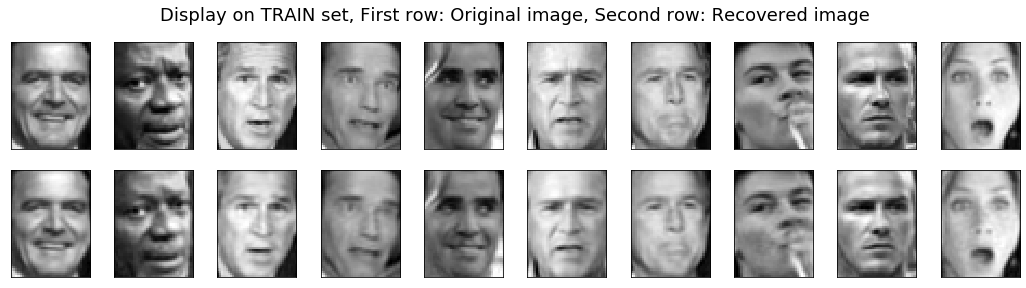

In [183]:
plot_faces_compare(X_train, X_train_recovered, h, w, 0.8, 10, 
                   suptitle="Display on TRAIN set, First row: Original image, Second row: Recovered image")

In [184]:
X_test_recovered = reduce_and_recover(U_reduce, X_test)

# Reverse the mean normalisation
X_test_recovered = (X_test_recovered.T + mu_test).T
X_test_ = (X_test.T + mu_test).T

# Compute the image similarity in %
sim_test = image_similarity(X_test_, X_test_recovered)

print("The test images are {:.3f}% similar".format(sim_test * 100))

The test images are 98.473% similar


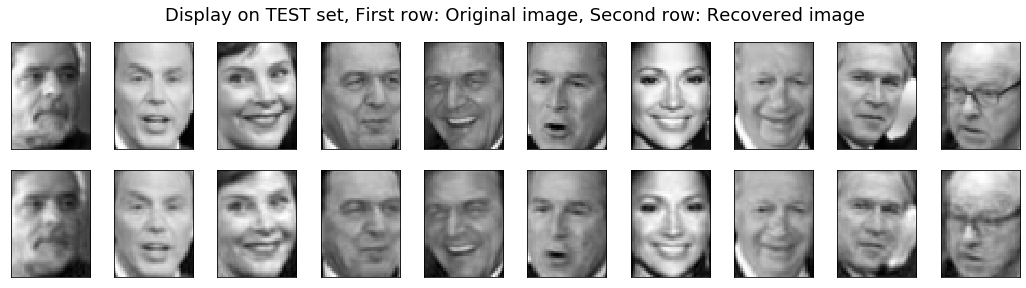

In [185]:
plot_faces_compare(X_test, X_test_recovered, h, w, 0.8, 10,
                  suptitle="Display on TEST set, First row: Original image, Second row: Recovered image")

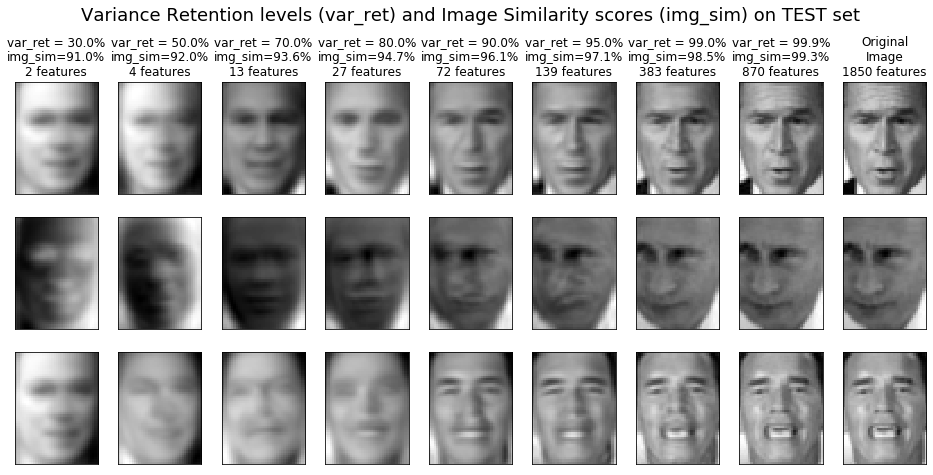

In [186]:
n_images = 3
scaling = 0.9
variance_levels = [0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]
test_or_train = "TEST" # "TRAIN" or "TEST

X_plot, X_plot_, mu_plot = None, None, None
if test_or_train == "TEST":
    X_plot, X_plot_, mu_plot = X_test, X_test_, mu_test
else:
    X_plot, X_plot_, mu_plot = X_train, X_train_, mu_train

series_images, series_sim, series_features = [], [], []
image_id = np.random.randint(0, X_plot.shape[0], size=(1,n_images))
n_levels = len(variance_levels)

# Perform PCA and recovery for all variance levels
for i_var in variance_levels:
    tmp_U_reduce = get_U_reduce(i_var, eigvals)[0]
    tmp_X_recovered = (reduce_and_recover(tmp_U_reduce, X_plot).T + mu_plot).T
    
    series_features.append(tmp_U_reduce.shape[1])
    series_sim.append(image_similarity(X_plot_, tmp_X_recovered))    
    series_images.append(tmp_X_recovered[image_id])

series_images.append(X_plot[image_id])

# Print example images for different variance levels
plt.figure(figsize=(1.8 * n_levels * scaling, 2.4 * n_images * scaling))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.82, hspace=.20)
plt.suptitle("Variance Retention levels (var_ret) and Image Similarity scores (img_sim) on {} set".format(
        test_or_train), fontsize = 18)

for i in range(n_levels + 1):
    for j in range(n_images):
        plt.subplot(n_images, n_levels + 1, j * (n_levels+1) + i + 1 )
        plt.imshow(series_images[i][0][j].reshape((h, w)), cmap=plt.cm.gray)
        if j == 0:
            if i == n_levels:
                plt.title("Original\nImage\n{} features".format(X_test_.shape[1]))
            else:
                plt.title("var_ret = {:.1f}%\nimg_sim={:.1f}%\n{} features".format(
                        variance_levels[i] * 100, series_sim[i] * 100, series_features[i]))
        plt.xticks(())
        plt.yticks(())

plt.show()

## Reduction through Flat Auto-Encoder

In [243]:
from time import time
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [187]:
# Standardisation
mu_stand = X.mean(axis=0)
sigma_stand = X.std(axis=0)
X_stand = ((X - mu_stand) / sigma_stand)

# Reverse conversion
# X = X_stand * sigma_stand + mu_stand

In [204]:
test_ratio = 0.15
val_ratio = 0.15

n_samples_train = int((1-test_ratio-val_ratio) * X.shape[0])
n_samples_val = int(test_ratio * X.shape[0])

X_train = X[:n_samples_train]
X_val = X[n_samples_train:(n_samples_train + n_samples_val)]
X_test = X[(n_samples_train + n_samples_val):]

X_stand_train = X_stand[:n_samples_train]
X_stand_val = X_stand[n_samples_train:(n_samples_train + n_samples_val)]
X_stand_test = X_stand[n_samples_train:]

print("{} samples in train set".format(X_train.shape[0]))
print("{} samples in validation set".format(X_val.shape[0]))
print("{} samples in test set".format(X_test.shape[0]))

2116 samples in train set
453 samples in validation set
454 samples in test set


In [234]:
# Building the model
model = Sequential()

model.add(Dense(768, activation='relu', input_shape=(X_stand_train.shape[1],)))
model.add(Dense(383, activation='relu')) # Using the same feature number as PCA with 99% var retention
model.add(Dense(768, activation='relu'))
model.add(Dense(X_stand_train.shape[1], activation='linear'))

# Compiling the model
model.compile(loss = 'mse', optimizer=adam(lr=0.0001))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 768)               1421568   
_________________________________________________________________
dense_90 (Dense)             (None, 383)               294527    
_________________________________________________________________
dense_91 (Dense)             (None, 768)               294912    
_________________________________________________________________
dense_92 (Dense)             (None, 1850)              1422650   
Total params: 3,433,657
Trainable params: 3,433,657
Non-trainable params: 0
_________________________________________________________________


In [252]:
mcp = ModelCheckpoint("models/weights.{val_loss:.3f}.{epoch:02d}-.hdf5", save_best_only=True)
ecp = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

start = time()

history = model.fit(X_stand_train, X_stand_train, 
                    epochs=200, batch_size=32, 
                    verbose=2, validation_data=(X_stand_val, X_stand_val),
                    callbacks=[mcp, ecp])

print("Total training time {:.0f}s".format(time() - start))

Train on 2116 samples, validate on 453 samples
Epoch 1/200
 - 3s - loss: 0.0733 - val_loss: 0.1182
Epoch 2/200
 - 3s - loss: 0.0727 - val_loss: 0.1174
Epoch 3/200
 - 3s - loss: 0.0715 - val_loss: 0.1163
Epoch 4/200
 - 3s - loss: 0.0702 - val_loss: 0.1161
Epoch 5/200
 - 3s - loss: 0.0700 - val_loss: 0.1158
Epoch 6/200
 - 3s - loss: 0.0686 - val_loss: 0.1146
Epoch 7/200
 - 3s - loss: 0.0679 - val_loss: 0.1140
Epoch 8/200
 - 3s - loss: 0.0671 - val_loss: 0.1139
Epoch 9/200
 - 4s - loss: 0.0661 - val_loss: 0.1129
Epoch 10/200
 - 4s - loss: 0.0656 - val_loss: 0.1123
Epoch 11/200
 - 3s - loss: 0.0646 - val_loss: 0.1118
Epoch 12/200
 - 3s - loss: 0.0643 - val_loss: 0.1111
Epoch 13/200
 - 3s - loss: 0.0635 - val_loss: 0.1109
Epoch 14/200
 - 3s - loss: 0.0629 - val_loss: 0.1103
Epoch 15/200
 - 3s - loss: 0.0620 - val_loss: 0.1100
Epoch 16/200
 - 4s - loss: 0.0615 - val_loss: 0.1089
Epoch 17/200
 - 4s - loss: 0.0608 - val_loss: 0.1091
Epoch 18/200
 - 3s - loss: 0.0600 - val_loss: 0.1084
Epoch 19

Epoch 154/200
 - 3s - loss: 0.0296 - val_loss: 0.0892
Epoch 155/200
 - 3s - loss: 0.0293 - val_loss: 0.0894
Epoch 156/200
 - 3s - loss: 0.0292 - val_loss: 0.0896
Epoch 157/200
 - 3s - loss: 0.0294 - val_loss: 0.0892
Epoch 158/200
 - 3s - loss: 0.0292 - val_loss: 0.0892
Epoch 159/200
 - 3s - loss: 0.0290 - val_loss: 0.0890
Epoch 160/200
 - 4s - loss: 0.0289 - val_loss: 0.0891
Epoch 161/200
 - 3s - loss: 0.0292 - val_loss: 0.0893
Epoch 162/200
 - 4s - loss: 0.0298 - val_loss: 0.0909
Epoch 163/200
 - 4s - loss: 0.0303 - val_loss: 0.0905
Epoch 164/200
 - 4s - loss: 0.0303 - val_loss: 0.0895
Epoch 165/200
 - 4s - loss: 0.0292 - val_loss: 0.0895
Epoch 166/200
 - 4s - loss: 0.0289 - val_loss: 0.0890
Epoch 167/200
 - 4s - loss: 0.0292 - val_loss: 0.0895
Epoch 168/200
 - 4s - loss: 0.0287 - val_loss: 0.0894
Epoch 169/200
 - 4s - loss: 0.0283 - val_loss: 0.0888
Epoch 170/200
 - 4s - loss: 0.0280 - val_loss: 0.0884
Epoch 171/200
 - 3s - loss: 0.0277 - val_loss: 0.0888
Epoch 172/200
 - 3s - loss: 

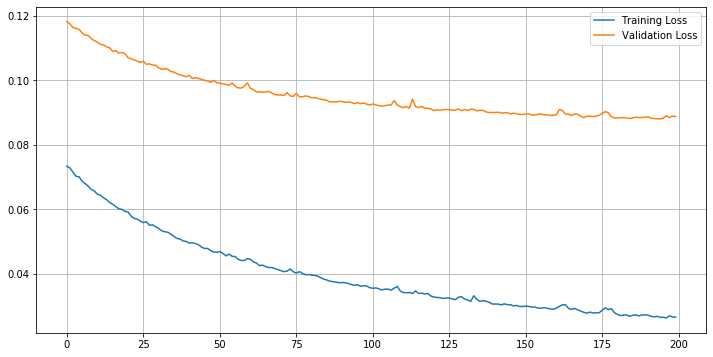

In [256]:
plt.figure(figsize=(12,6))
plt.plot(history.epoch, history.history["loss"], label="Training Loss")
plt.plot(history.epoch, history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.grid()
plt.show()

The train images are 98.086% similar


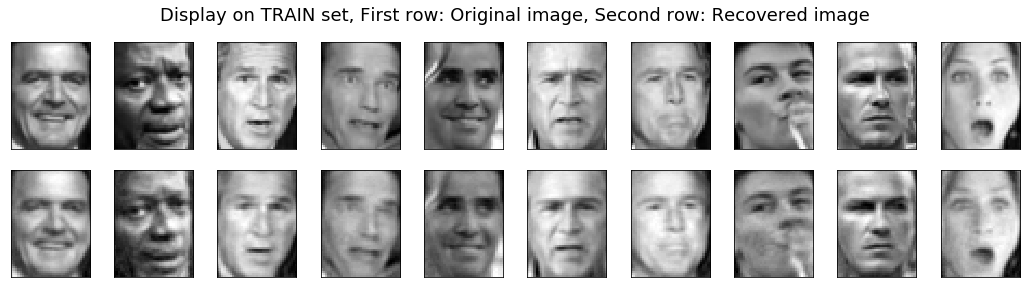

In [254]:
X_predict_train = model.predict(X_stand_train)
X_predict_train = X_predict_train * sigma_stand + mu_stand

fae_sim_train = image_similarity(X_predict_train, X_train)
print("The train images are {:.3f}% similar".format(fae_sim_train*100))

plot_faces_compare(X_train, X_predict_train, h, w, 0.8, 10, 
                   suptitle="Display on TRAIN set, First row: Original image, Second row: Recovered image")

The test images are 96.517% similar


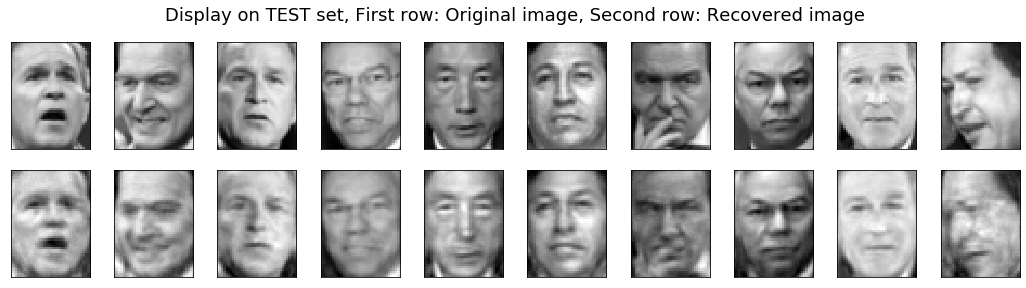

In [255]:
X_predict_val = model.predict(X_stand_val)
X_predict_val = X_predict_val * sigma_stand + mu_stand

fae_sim_val = image_similarity(X_predict_val, X_val)
print("The test images are {:.3f}% similar".format(fae_sim_val*100))

plot_faces_compare(X_val, X_predict_val, h, w, 0.8, 10, 
                   suptitle="Display on TEST set, First row: Original image, Second row: Recovered image")

## Reduction through Convolutional Auto-Encoder

In [407]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import InputLayer, Dropout, Flatten, Dense, Reshape
from keras.models import Sequential

In [442]:
X_2D = X.reshape(X_stand.shape[0], h, w, 1)
X_2D = X_2D[:, 1:49, 0:36, :]
dummy1, h2, w2, dummy2 = X_2D.shape

X_stand_2D = X_2D.reshape(X_2D.shape[0], h2*w2)

# Standardisation
mu_stand_2D = X_stand_2D.mean(axis=0)
sigma_stand_2D = X_stand_2D.std(axis=0)
X_stand_2D = ((X_stand_2D - mu_stand_2D) / sigma_stand_2D)

X_stand_2D = X_stand_2D.reshape(X_stand_2D.shape[0], h2, w2, 1)

print("Images cropped to {}x{}".format(h2, w2))

Images cropped to 48x36


In [443]:
test_ratio = 0.15
val_ratio = 0.15

n_samples_train = int((1-test_ratio-val_ratio) * X2.shape[0])
n_samples_val = int(test_ratio * X2.shape[0])

X_train_2D = X_2D[:n_samples_train]
X_val_2D = X_2D[n_samples_train:(n_samples_train + n_samples_val)]
X_test_2D = X_2D[(n_samples_train + n_samples_val):]

X_stand_train_2D = X_stand_2D[:n_samples_train]
X_stand_val_2D = X_stand_2D[n_samples_train:(n_samples_train + n_samples_val)]
X_stand_test_2D = X_stand_2D[n_samples_train:]

print("{} samples in train set".format(X_train.shape[0]))
print("{} samples in validation set".format(X_val.shape[0]))
print("{} samples in test set".format(X_test.shape[0]))

2116 samples in train set
453 samples in validation set
454 samples in test set


In [460]:
model = Sequential()

kernel = (2,2)
stride = (1,1)
pool = (2,2)
padding = "same"
border = "same"

# Decoder Architecture
model.add(InputLayer(input_shape=(h2, w2, 1)))
model.add(Conv2D(filters=8, kernel_size=kernel, strides=stride, padding=padding, activation='relu'))
model.add(MaxPooling2D(pool_size=pool, border_mode=border))
model.add(Conv2D(filters=16, kernel_size=kernel, strides=stride, padding=padding, activation='relu'))
model.add(MaxPooling2D(pool_size=pool, border_mode=border))
model.add(Conv2D(filters=64, kernel_size=kernel, strides=stride, padding=padding, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,3), border_mode=border))
model.add(Flatten())

# Compressed layer
model.add(Dense(383, activation='relu')) # Using the same feature number as PCA with 99% var retention

# Encoder Architecture
model.add(Dense(1152, activation='relu'))
model.add(Reshape(target_shape=(6, 3, 64)))
model.add(UpSampling2D(size=(2,3)))
model.add(Conv2DTranspose(filters=32, kernel_size=kernel, strides=stride, padding="same", activation='relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2DTranspose(filters=16, kernel_size=kernel, strides=stride, padding="same", activation='relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2DTranspose(filters=8, kernel_size=kernel, strides=stride, padding="same", activation='relu'))
model.add(Conv2DTranspose(filters=1, kernel_size=kernel, strides=stride, padding="same", activation='relu'))

# Compiling the model
model.compile(loss = 'mse', optimizer=adam(lr=0.0001))
model.summary()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
  if sys.path[0] == '':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 3), padding="same")`
  app.launch_new_instance()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_407 (Conv2D)          (None, 48, 36, 8)         40        
_________________________________________________________________
max_pooling2d_392 (MaxPoolin (None, 24, 18, 8)         0         
_________________________________________________________________
conv2d_408 (Conv2D)          (None, 24, 18, 16)        528       
_________________________________________________________________
max_pooling2d_393 (MaxPoolin (None, 12, 9, 16)         0         
_________________________________________________________________
conv2d_409 (Conv2D)          (None, 12, 9, 64)         4160      
_________________________________________________________________
max_pooling2d_394 (MaxPoolin (None, 6, 3, 64)          0         
_________________________________________________________________
flatten_70 (Flatten)         (None, 1152)              0         
__________

In [464]:
model = Sequential()

kernel = (2,2)
stride = (1,1)
pool = (2,2)
padding = "same"
border = "same"

# Decoder Architecture
model.add(InputLayer(input_shape=(h2, w2, 1)))
model.add(Conv2D(filters=32, kernel_size=kernel, strides=stride, padding=padding, activation='relu'))
model.add(MaxPooling2D(pool_size=pool, border_mode=border))
model.add(Conv2D(filters=64, kernel_size=kernel, strides=stride, padding=padding, activation='relu'))
model.add(MaxPooling2D(pool_size=pool, border_mode=border))
model.add(Conv2D(filters=128, kernel_size=kernel, strides=stride, padding=padding, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,3), border_mode=border))
model.add(Flatten())

# Compressed layer
model.add(Dense(383, activation='relu')) # Using the same feature number as PCA with 99% var retention

# Encoder Architecture
model.add(Dense(2304, activation='relu'))
model.add(Reshape(target_shape=(6, 3, 128)))
model.add(UpSampling2D(size=(2,3)))
model.add(Conv2DTranspose(filters=64, kernel_size=kernel, strides=stride, padding="same", activation='relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2DTranspose(filters=32, kernel_size=kernel, strides=stride, padding="same", activation='relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2DTranspose(filters=1, kernel_size=kernel, strides=stride, padding="same", activation='relu'))

# Compiling the model
model.compile(loss = 'mse', optimizer=adam(lr=0.0001))
model.summary()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
  if sys.path[0] == '':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 3), padding="same")`
  app.launch_new_instance()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_413 (Conv2D)          (None, 48, 36, 32)        160       
_________________________________________________________________
max_pooling2d_398 (MaxPoolin (None, 24, 18, 32)        0         
_________________________________________________________________
conv2d_414 (Conv2D)          (None, 24, 18, 64)        8256      
_________________________________________________________________
max_pooling2d_399 (MaxPoolin (None, 12, 9, 64)         0         
_________________________________________________________________
conv2d_415 (Conv2D)          (None, 12, 9, 128)        32896     
_________________________________________________________________
max_pooling2d_400 (MaxPoolin (None, 6, 3, 128)         0         
_________________________________________________________________
flatten_72 (Flatten)         (None, 2304)              0         
__________

In [ ]:
mcp = ModelCheckpoint("models/weights.{val_loss:.3f}.{epoch:02d}-.hdf5", save_best_only=True)
ecp = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

start = time()

history = model.fit(X_stand_train_2D, X_stand_train_2D, 
                    epochs=100, batch_size=32, 
                    verbose=2, validation_data=(X_stand_val_2D, X_stand_val_2D),
                    callbacks=[mcp, ecp])

print("Total training time {:.0f}s".format(time() - start))

Train on 2116 samples, validate on 453 samples
Epoch 1/100
 - 17s - loss: 0.8506 - val_loss: 0.7905
Epoch 2/100
 - 10s - loss: 0.7439 - val_loss: 0.7527
Epoch 3/100
 - 9s - loss: 0.7144 - val_loss: 0.7333
Epoch 4/100
 - 9s - loss: 0.6971 - val_loss: 0.7201
Epoch 5/100
 - 9s - loss: 0.6859 - val_loss: 0.7160
Epoch 6/100
 - 9s - loss: 0.6772 - val_loss: 0.7034
Epoch 7/100
 - 9s - loss: 0.6699 - val_loss: 0.6975
Epoch 8/100
 - 9s - loss: 0.6646 - val_loss: 0.6939
Epoch 9/100
 - 9s - loss: 0.6598 - val_loss: 0.6901
Epoch 10/100
 - 9s - loss: 0.6560 - val_loss: 0.6873
Epoch 11/100
 - 9s - loss: 0.6525 - val_loss: 0.6856
Epoch 12/100
 - 9s - loss: 0.6498 - val_loss: 0.6819
Epoch 13/100
 - 9s - loss: 0.6467 - val_loss: 0.6797
Epoch 14/100
 - 9s - loss: 0.6438 - val_loss: 0.6788
Epoch 15/100
 - 9s - loss: 0.6422 - val_loss: 0.6757
Epoch 16/100
 - 9s - loss: 0.6399 - val_loss: 0.6762
Epoch 17/100
 - 9s - loss: 0.6387 - val_loss: 0.6729
Epoch 18/100
 - 9s - loss: 0.6365 - val_loss: 0.6729
Epoch 

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.epoch, history.history["loss"], label="Training Loss")
plt.plot(history.epoch, history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.grid()
plt.show()

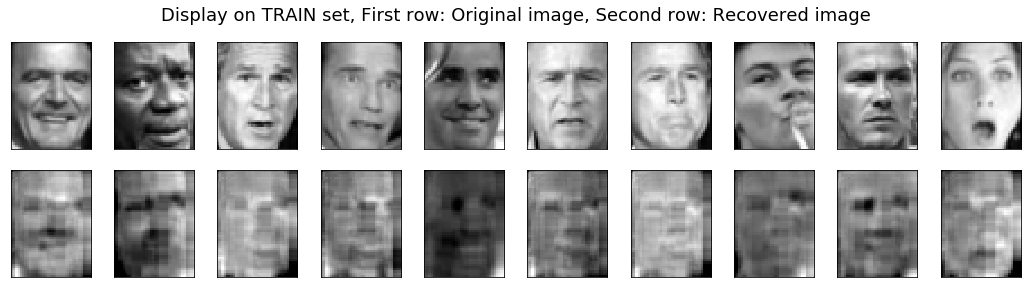

In [462]:
X_predict_train = model.predict(X_train_2D)
X_predict_train = X_predict_train.reshape(X_predict_train.shape[0], h2*w2)
X_predict_train = X_predict_train * sigma_stand_2D + mu_stand_2D

# fae_sim_train = image_similarity(X_predict_train, X_train)
# print("The train images are {:.3f}% similar".format(fae_sim_train*100))

plot_faces_compare(X_train_2D, X_predict_train, h2, w2, 0.8, 10, 
                   suptitle="Display on TRAIN set, First row: Original image, Second row: Recovered image")